In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import lxml
import cchardet
import time
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

D:\Downloads\Anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Department of Conservation (DOC)
The following document is from the open data of the Department of Conservation (DOC) in New Zealand. As seen below, it provides 3,262 unique trail names with global positioning

In [3]:
doc = pd.read_csv('data/DOC_Tracks.csv')
doc.head()
doc.shape
doc.info()

,OBJECTID,CAPTURE_ACCURACY,EQUIPMENT,DESCRIPTION,STATUS,OBJECT_TYPE_DESCRIPTION,GlobalID,SHAPE_Length
0,521495,2.0,100044818,TAUHERENIKAU GORGE TRACK,OPEN,Tramping Track,{3AAF81F3-73B3-4F88-A796-17B07DFF1A81},2310.732688
1,521496,2.0,100044819,MOUNT HOLDSWORTH TO JUMBO HUT,OPEN,Easy Tramping Track,{E84ABC5A-4EBE-4AE8-859E-48D9292A851E},3761.813276
2,521497,2.0,100044820,RAINGAUGE SPUR,OPEN,Easy Tramping Track,{83173518-A632-4A4D-8076-092A7851298F},2129.463229
3,521498,2.0,100044821,BARRA TRACK - THE PINES TO BLAKE STREAM,OPEN,Tramping Track,{96C9A611-59BA-4A5B-AD9B-ACAC7F3AC152},2046.447855
4,521499,2.0,100044822,EAST HOLDSWORTH TRACK,OPEN,Tramping Track,{E460CE11-526E-4DF0-99BF-9BF5EB00D38F},3508.240620


(3262, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OBJECTID                 3262 non-null   int64  
 1   CAPTURE_ACCURACY         3260 non-null   float64
 2   EQUIPMENT                3262 non-null   int64  
 3   DESCRIPTION              3262 non-null   object 
 4   STATUS                   3262 non-null   object 
 5   OBJECT_TYPE_DESCRIPTION  3262 non-null   object 
 6   GlobalID                 3262 non-null   object 
 7   SHAPE_Length             3262 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 204.0+ KB


# WalkingKiwi.co.nz
Need some trail information for these tracks! The following is a scraping of WalkingKiwi's front page for all trail information

In [3]:
%%time
URL = 'https://walkingkiwi.co.nz/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
print(soup.prettify())

<script>
 var trackArray = [];var trackLocation = {
        lng: 173.096578,
        lat: -41.494357,
        index: 0,
        time: '11h 39m',
        length: '11.51km',
        type: 'Tramping Track',
        url: '-l-wairoa-road-end-to-barrys-flat',
        name: ' L. Wairoa Road End to Barrys Flat'};
trackArray.push(trackLocation);var trackLocation = {
        lng: 176.006116,
        lat: -37.927966,
        index: 1,
        time: '2h 43m',
        length: '6.45km',
        type: 'Tramping Track',
        url: '-ngatuhoa-stream-track',
        name: ' Ngatuhoa Stream Track'};
trackArray.push(trackLocation);var trackLocation = {
        lng: 168.594405,
        lat: -43.975153,
        index: 2,
        time: '2h 18m',
        length: '5.84km',
        type: 'Route',
        url: '-coastal-smoothwaterstaffordhut-route',
        name: '(coastal) Smoothwater-staffordhut Route'};
trackArray.push(trackLocation);var trackLocation = {
        lng: 168.545144,
        lat: -43.996206,
 

In [4]:
script = soup.find('script')
script = str(script)
info = script.split(';')
# there are a few track names that had a semi-colon which needs to be corrected
info[287:289] = [''.join(info[287:289])]
info[289:291] = [''.join(info[289:291])]
info[2745:2747] = [''.join(info[2745:2747])]
info[5967:5969] = [''.join(info[5967:5969])]

In [5]:
split = []
for i in range(1,len(info),2):
    q = info[i].split('=')
    for n in range(1,len(q)):
        split.append(q[n])
        
k = []
for i in range(len(split)):
    k.append(split[i].replace('\n        ','').strip(' '))
    
data = []
for i in k:
    result = re.search('{(.*)}', i)
    each = result.group(1)
    data.append(each)


In [486]:
df = pd.DataFrame([p.split(',') for p in data], columns=['lng','lat','index','time','length','type','url','name','unknown'])

In [487]:
# unknown appeared due to commas in the name so we will fix that
df.unknown.fillna(value='', inplace=True)
df['name'] = df['name'] + '' + df['unknown']
df.drop(columns=['unknown','index'], inplace=True)
# remove string of column names from the data
df['lng'] = df['lng'].map(lambda x: x.lstrip('lng:'))
df['lat'] = df['lat'].map(lambda x: x.lstrip('lat:'))
df['time'] = df['time'].map(lambda x: x.lstrip("time: '").rstrip("'"))
df['length'] = df['length'].map(lambda x: x.lstrip("length: '").rstrip("km'"))
df.rename(columns={"length": "length_km"}, inplace=True)
df['type'] = df['type'].map(lambda x: x.lstrip("type: '").rstrip("'"))
df['url'] = df['url'].map(lambda x: x.replace("url: '","").rstrip("'"))
df['name'] = df['name'].map(lambda x: x.lstrip("name: '").rstrip("'"))
# re-order the columns
df = df[['name', 'type', 'time', 'length_km', 'lng','lat','url']]
# adjust time from XXhXXm to hours
df['time'] = df['time'].map(lambda x: re.sub("[^0-9]", "", x))
import time
hours = []
for x in df.time:
    t = time.strptime(x,"%H%M")
    hours.append(t.tm_hour + (t.tm_min/60))
df['time']  = hours
df.rename(columns={"time": "time_h"}, inplace=True)

df.head()
df.shape
df.info()

,name,type,time_h,length_km,lng,lat,url
0,L. Wairoa Road End to Barrys Flat,Tramping Track,11.650000,11.51,173.096578,-41.494357,-l-wairoa-road-end-to-barrys-flat
1,Ngatuhoa Stream Track,Tramping Track,2.716667,6.45,176.006116,-37.927966,-ngatuhoa-stream-track
2,(coastal) Smoothwater-staffordhut Route,Route,21.133333,5.84,168.594405,-43.975153,-coastal-smoothwaterstaffordhut-route
3,(inland) Smoothwater-staffordhut Route,Route,2.983333,6.99,168.545144,-43.996206,-inland-smoothwaterstaffordhut-route
4,1000 Acres (1000 Ac Jcn to Pp Hut),Tramping Track,23.100000,4.42,172.331671,-41.649679,1000-acres-1000-ac-jcn-to-pp-hut


(3119, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3119 entries, 0 to 3118
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       3119 non-null   object 
 1   type       3119 non-null   object 
 2   time_h     3119 non-null   float64
 3   length_km  3119 non-null   object 
 4   lng        3119 non-null   object 
 5   lat        3119 non-null   object 
 6   url        3119 non-null   object 
dtypes: float64(1), object(6)
memory usage: 170.7+ KB


## Restart Kernel Load Point -- After Front Page Scrape

In [1136]:
#df.to_csv('data/WalkingKiwi_Tracks.csv')
df = pd.read_csv('data/WalkingKiwi_Tracks.csv', index_col=0)
doc = pd.read_csv('data/DOC_Tracks.csv')

In [492]:
# each hiking trail url to gain elevation information
track_urls = df.url.tolist()
print(track_urls)

['-l-wairoa-road-end-to-barrys-flat', '-ngatuhoa-stream-track', '-coastal-smoothwaterstaffordhut-route', '-inland-smoothwaterstaffordhut-route', '1000-acres-1000-ac-jcn-to-pp-hut', '1000-acres-pp-hut-to-lar-hut', '1220-track', '1st-carpark-easement', '3-mile-pack-track', '6-tk-jnc-near-te-panaa-to-taurawharona', '7mile-creek-bushline-to-dillons-hut-trk', 'abel-tasman-inland-trk-hoakesporters', 'abel-tasman-inland-trk-tlinehoakes', 'abel-tasman-memorial-walk', 'access-tracks-around-rangatira-flat', 'acheron-lookout-loop-walk', 'acland-falls-track', 'acton-bushedgeacton-cromel-route-junctn', 'acton-hut-sitecromel-base-hut-junctn', 'acton-cromel-rte-junctcromelbranch-hut', 'ada-track', 'adeanes-bush-sr-track', 'adventure-ridge-route', 'ahukawakawa-track', 'ahuriri-estuary-track', 'ahuriri-valley-track', 'ake-ake-pt-track', 'akersten-bay-track', 'albert-burn-track', 'alborns-walk', 'alder-track', 'alex-knob-track', 'alexandra-210-to-205', 'alford-forest-easement', 'alice-nash-h-lodge-to-ir

In [493]:
# start them empty over here and then we'll add to them as we parse through the urls
coordinates = []
trackElevation = []
length_confirm = []
maxElevation = []
minElevation = []

In [494]:
def scrape_hikes(track_urls):
    for url in track_urls:
        URL = 'https://walkingkiwi.co.nz/track/' + str(url)
        session = requests.Session()
        page = session.get(URL, stream=True)
        soup = BeautifulSoup(page.content, 'html.parser')
    
        script = soup.find_all('script')[1]
        script = str(script)
        info = script.split(';')
    
        coordinates.append(info[2])
        trackElevation.append(info[3])
        length_confirm.append(info[4])
        maxElevation.append(info[5])
        minElevation.append(info[6])
        soup.decompose()
        page.close()
    print('Scrape Complete. Lists Appended')

In [1133]:
scrape_hikes(track_urls)

Scrape Complete. Lists Appended


In [1137]:
df['coordinates'] = coordinates
df['trackElevation'] = trackElevation
df['lengthcheck'] = length_confirm
df['maxElevation'] = maxElevation
df['minElevation'] = minElevation
df.head()

,name,type,time_h,length_km,lng,lat,url,coordinates,trackElevation,lengthcheck,maxElevation,minElevation
0,L. Wairoa Road End to Barrys Flat,Tramping Track,11.650000,11.51,173.096578,-41.494357,-l-wairoa-road-end-to-barrys-flat,"var coordArray = ["""","" 173.096578,-41.494357 ...",var elevArray = [192.003540039000000660962541...,var trackLength = 11.51,var maxElevation = 407.1,var minElevation = 178.5
1,Ngatuhoa Stream Track,Tramping Track,2.716667,6.45,176.006116,-37.927966,-ngatuhoa-stream-track,"var coordArray = ["" "","" 176.006116,-37.927966...",var elevArray = [325.382751464839998334355186...,var trackLength = 6.45,var maxElevation = 461,var minElevation = 318.8
2,(coastal) Smoothwater-staffordhut Route,Route,21.133333,5.84,168.594405,-43.975153,-coastal-smoothwaterstaffordhut-route,"var coordArray = ["""","" 168.594405,-43.975153 ...","var elevArray = [1,0.317498326301569988583395...",var trackLength = 5.84,var maxElevation = 37.6,var minElevation = 0
3,(inland) Smoothwater-staffordhut Route,Route,2.983333,6.99,168.545144,-43.996206,-inland-smoothwaterstaffordhut-route,"var coordArray = ["""","" 168.545144,-43.996206 ...",var elevArray = [2.98784279823299980805018094...,var trackLength = 6.99,var maxElevation = 253.1,var minElevation = 1.3
4,1000 Acres (1000 Ac Jcn to Pp Hut),Tramping Track,23.100000,4.42,172.331671,-41.649679,1000-acres-1000-ac-jcn-to-pp-hut,"var coordArray = ["""","" 172.331671,-41.649679 ...","var elevArray = [345.5771484375,476.229125976...",var trackLength = 4.42,var maxElevation = 1099,var minElevation = 345.6


In [1165]:
# save point
#df.to_csv('data/WalkingKiwi_Tracks2.csv')

Clean the new appended data

In [1151]:
df.coordinates[0:1]

0     var coordArray = [""," 173.096578,-41.494357 ...
Name: coordinates, dtype: object

In [1166]:
# remove string of column names from the data
df['coordinates'] = df['coordinates'].map(lambda x: str(x).lstrip(' var coordArray = [""," ').rstrip('"]'))
df['trackElevation'] = df['trackElevation'].map(lambda x: str(x).lstrip(' var elevArray = [').rstrip(']'))
df['lengthcheck'] = df['lengthcheck'].map(lambda x: str(x).lstrip(" var trackLength = ").rstrip("'"))
df['maxElevation'] = df['maxElevation'].map(lambda x: str(x).lstrip(" var maxElevation = ").rstrip("'"))
df['minElevation'] = df['minElevation'].map(lambda x: str(x).lstrip(" var minElevation = ").rstrip("'"))

df.head()
df.shape
df.info()

,name,type,time_h,length_km,lng,lat,url,coordinates,trackElevation,lengthcheck,maxElevation,minElevation
0,L. Wairoa Road End to Barrys Flat,Tramping Track,11.650000,11.51,173.096578,-41.494357,-l-wairoa-road-end-to-barrys-flat,"173.096578,-41.494357 173.096810,-41.494361 17...",192.003540039000000660962541587650775909423828...,11.51,407.1,178.5
1,Ngatuhoa Stream Track,Tramping Track,2.716667,6.45,176.006116,-37.927966,-ngatuhoa-stream-track,"176.006116,-37.927966 176.006240,-37.927909 17...",325.382751464839998334355186671018600463867187...,6.45,461,318.8
2,(coastal) Smoothwater-staffordhut Route,Route,21.133333,5.84,168.594405,-43.975153,-coastal-smoothwaterstaffordhut-route,"168.594405,-43.975153 168.594300,-43.975123 16...","1,0.317498326301569988583395343084703199565410...",5.84,37.6,0
3,(inland) Smoothwater-staffordhut Route,Route,2.983333,6.99,168.545144,-43.996206,-inland-smoothwaterstaffordhut-route,"168.545144,-43.996206 168.545165,-43.996220 16...",2.98784279823299980805018094542901962995529174...,6.99,253.1,1.3
4,1000 Acres (1000 Ac Jcn to Pp Hut),Tramping Track,23.100000,4.42,172.331671,-41.649679,1000-acres-1000-ac-jcn-to-pp-hut,"172.331671,-41.649679 172.330260,-41.646983 17...","345.5771484375,476.229125976559998889570124447...",4.42,1099,345.6


(3119, 12)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3119 entries, 0 to 3118
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            3119 non-null   object 
 1   type            3119 non-null   object 
 2   time_h          3119 non-null   float64
 3   length_km       3119 non-null   float64
 4   lng             3119 non-null   float64
 5   lat             3119 non-null   float64
 6   url             3119 non-null   object 
 7   coordinates     3119 non-null   object 
 8   trackElevation  3119 non-null   object 
 9   lengthcheck     3119 non-null   object 
 10  maxElevation    3119 non-null   object 
 11  minElevation    3119 non-null   object 
dtypes: float64(4), object(8)
memory usage: 316.8+ KB


In [1204]:
df.lengthcheck = pd.to_numeric(df.lengthcheck, errors='coerce')
df.maxElevation = pd.to_numeric(df.maxElevation, errors='coerce')
df.minElevation = pd.to_numeric(df.minElevation, errors='coerce')

In [1205]:
df.drop(columns='lengthcheck', inplace=True)
df['totalAscent'] = df.maxElevation - df.minElevation
df.head()
df.isnull().sum()

,name,type,time_h,length_km,lng,lat,url,coordinates,trackElevation,maxElevation,minElevation,totalAscent
0,L. Wairoa Road End to Barrys Flat,Tramping Track,11.650000,11.51,173.096578,-41.494357,-l-wairoa-road-end-to-barrys-flat,"173.096578,-41.494357 173.096810,-41.494361 17...",192.003540039000000660962541587650775909423828...,407.1,178.5,228.6
1,Ngatuhoa Stream Track,Tramping Track,2.716667,6.45,176.006116,-37.927966,-ngatuhoa-stream-track,"176.006116,-37.927966 176.006240,-37.927909 17...",325.382751464839998334355186671018600463867187...,461.0,318.8,142.2
2,(coastal) Smoothwater-staffordhut Route,Route,21.133333,5.84,168.594405,-43.975153,-coastal-smoothwaterstaffordhut-route,"168.594405,-43.975153 168.594300,-43.975123 16...","1,0.317498326301569988583395343084703199565410...",37.6,0.0,37.6
3,(inland) Smoothwater-staffordhut Route,Route,2.983333,6.99,168.545144,-43.996206,-inland-smoothwaterstaffordhut-route,"168.545144,-43.996206 168.545165,-43.996220 16...",2.98784279823299980805018094542901962995529174...,253.1,1.3,251.8
4,1000 Acres (1000 Ac Jcn to Pp Hut),Tramping Track,23.100000,4.42,172.331671,-41.649679,1000-acres-1000-ac-jcn-to-pp-hut,"172.331671,-41.649679 172.330260,-41.646983 17...","345.5771484375,476.229125976559998889570124447...",1099.0,345.6,753.4


name               0
type               0
time_h             0
length_km          0
lng                0
lat                0
url                0
coordinates        0
trackElevation     0
maxElevation      34
minElevation      34
totalAscent       34
dtype: int64

In [1206]:
df.dropna(inplace=True)
df.shape

(3085, 12)

In [1207]:
# save point
#df.to_csv('data/WalkingKiwi_Tracks2.csv')

## Kernel Restart Load Point -- After Initial Per-Trail Scrape

In [1165]:
df = pd.read_csv('data/WalkingKiwi_Tracks2.csv', index_col=0)
df.head()
track_urls = df.url.tolist()
print(track_urls[:5])

In [ ]:
# empty lists to gather info into
maxElevation = []
length = []
route_type = []
totalAscent = []
duration = []

In [ ]:
def scrape_hikes(track_urls):
    for url in track_urls:
        URL = 'https://walkingkiwi.co.nz/track/' + str(url)
        session = requests.Session()
        page = session.get(URL, stream=True)
        soup = BeautifulSoup(page.content, 'html.parser')
        #print(soup.prettify())
        data = soup.find('div', {'class':"content-box", 'id':"graph-container"})
        children = data.findChildren('div', {'class':"stat-text"})
        content = []
        for child in children:
            child = str(child)
            child = child.replace('<div class="stat-text">\n','')
            child = child.replace('                    ','')
            child = child.replace('\n<!-- ',';')
            child = child.replace(' (',';')
            child = child.replace(') -->\n</div>','')
            child = child.split(';')
            content.append(child)
    
        maxElevation.append(content[0][0])
        length.append(content[0][1])
        route_type.append(content[0][2])
        totalAscent.append(content[1][0])
        duration.append(content[1][1])
    print('Scrape Completed. Lists Appended.')

In [ ]:
scrape_hikes(track_urls)

In [ ]:
df['maxElevation2'] = maxElevation
df['length2'] = length
df['type2'] = route_type
df['totalAscent2'] = totalAscent
df['time2'] = duration

df.head()
df.shape

In [43]:
# remove string of column names from the data
df['maxElevation2'] = df['maxElevation2'].map(lambda x: str(x).lstrip("\n").rstrip('m'))
df.maxElevation2 = pd.to_numeric(df.maxElevation2, errors='coerce')
df['length2'] = df['length2'].map(lambda x: str(x).rstrip(" km"))
df.length2 = pd.to_numeric(df.length2, errors='coerce')
df.rename(columns={"type2": "routeType"}, inplace=True)
df['totalAscent2'] = df['totalAscent2'].map(lambda x: str(x).rstrip("m"))
df.totalAscent2 = pd.to_numeric(df.totalAscent2, errors='coerce')
df['time2'] = df['time2'].map(lambda x: x.replace(' hr ', ':').replace(' min',''))
hours = []
for row in df.time2:
    hour, minutes = row.split(':')
    hours.append(round(int(hour) + (int(minutes)/60),2))
df.time_h = hours
df.length_km = df.length2
df.drop(columns=['time2','length2','maxElevation2','routeType'], inplace=True) # repeat columns proven to be duplicates, routeType all 'one-way' so useless information
df.rename(columns={"totalAscent": "netElevation",'totalAscent2':'totalAscent'}, inplace=True)
# re-order the columns
df = df[['name', 'type', 'time_h', 'length_km','minElevation','maxElevation','netElevation','totalAscent', 'lng','lat','coordinates','trackElevation','url']]
df.head()

,name,type,routeType,time_h,length_km,minElevation,maxElevation,netElevation,totalAscent,lng,lat,coordinates,trackElevation,url
0,L. Wairoa Road End to Barrys Flat,Tramping Track,one way,7.07,11.51,178.5,407.1,228.6,785.8,173.096578,-41.494357,"173.096578,-41.494357 173.096810,-41.494361 17...",192.003540039000000660962541587650775909423828...,-l-wairoa-road-end-to-barrys-flat
1,Ngatuhoa Stream Track,Tramping Track,one way,3.80,6.45,318.8,461.0,142.2,340.1,176.006116,-37.927966,"176.006116,-37.927966 176.006240,-37.927909 17...",325.382751464839998334355186671018600463867187...,-ngatuhoa-stream-track
2,(coastal) Smoothwater-staffordhut Route,Route,one way,2.30,5.84,0.0,37.6,37.6,214.0,168.594405,-43.975153,"168.594405,-43.975153 168.594300,-43.975123 16...","1,0.317498326301569988583395343084703199565410...",-coastal-smoothwaterstaffordhut-route
3,(inland) Smoothwater-staffordhut Route,Route,one way,2.98,6.99,1.3,253.1,251.8,387.9,168.545144,-43.996206,"168.545144,-43.996206 168.545165,-43.996220 16...",2.98784279823299980805018094542901962995529174...,-inland-smoothwaterstaffordhut-route
4,1000 Acres (1000 Ac Jcn to Pp Hut),Tramping Track,one way,3.35,4.42,345.6,1099.0,753.4,679.6,172.331671,-41.649679,"172.331671,-41.649679 172.330260,-41.646983 17...","345.5771484375,476.229125976559998889570124447...",1000-acres-1000-ac-jcn-to-pp-hut


In [59]:
#save point
#df.to_csv('data/WalkingKiwi_Tracks3.csv')

## Kernel Restart Load Point -- After Secondary Per-Trail Scrape

In [61]:
df = pd.read_csv('data/WalkingKiwi_Tracks3.csv', index_col=0)
df.head()
df.shape

,name,type,time_h,length_km,minElevation,maxElevation,netElevation,totalAscent,lng,lat,coordinates,trackElevation,url
0,L. Wairoa Road End to Barrys Flat,Tramping Track,7.07,11.51,178.5,407.1,228.6,785.8,173.096578,-41.494357,"173.096578,-41.494357 173.096810,-41.494361 17...",192.003540039000000660962541587650775909423828...,-l-wairoa-road-end-to-barrys-flat
1,Ngatuhoa Stream Track,Tramping Track,3.80,6.45,318.8,461.0,142.2,340.1,176.006116,-37.927966,"176.006116,-37.927966 176.006240,-37.927909 17...",325.382751464839998334355186671018600463867187...,-ngatuhoa-stream-track
2,(coastal) Smoothwater-staffordhut Route,Route,2.30,5.84,0.0,37.6,37.6,214.0,168.594405,-43.975153,"168.594405,-43.975153 168.594300,-43.975123 16...","1,0.317498326301569988583395343084703199565410...",-coastal-smoothwaterstaffordhut-route
3,(inland) Smoothwater-staffordhut Route,Route,2.98,6.99,1.3,253.1,251.8,387.9,168.545144,-43.996206,"168.545144,-43.996206 168.545165,-43.996220 16...",2.98784279823299980805018094542901962995529174...,-inland-smoothwaterstaffordhut-route
4,1000 Acres (1000 Ac Jcn to Pp Hut),Tramping Track,3.35,4.42,345.6,1099.0,753.4,679.6,172.331671,-41.649679,"172.331671,-41.649679 172.330260,-41.646983 17...","345.5771484375,476.229125976559998889570124447...",1000-acres-1000-ac-jcn-to-pp-hut


(3085, 13)

In [95]:
sns.set_theme(style='darkgrid', palette='deep',context='talk')

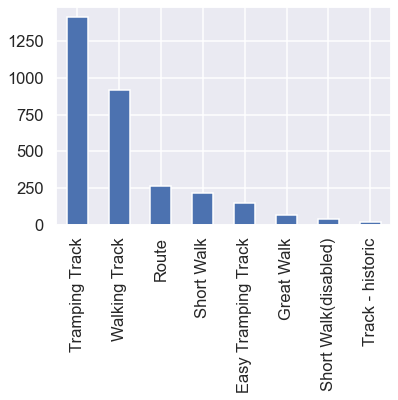

In [96]:
df.type.value_counts().plot(kind='bar');

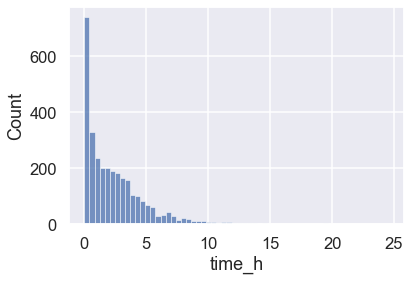

In [85]:
sns.histplot(x='time_h', data=df);

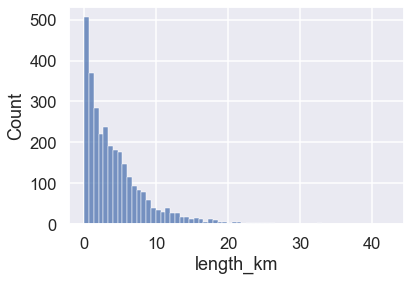

In [86]:
sns.histplot(x='length_km', data=df);

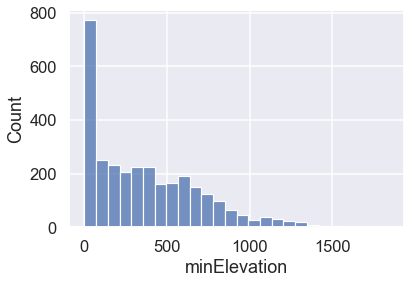

In [87]:
sns.histplot(x='minElevation', data=df);

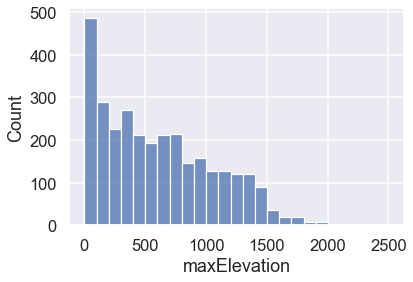

In [88]:
sns.histplot(x='maxElevation', data=df);

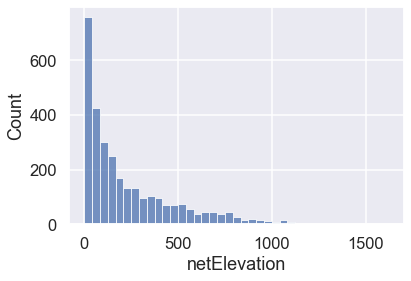

In [89]:
sns.histplot(x='netElevation', data=df);

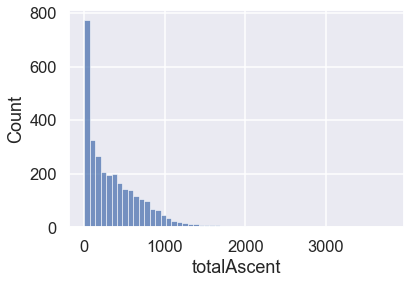

In [111]:
sns.histplot(x='totalAscent', data=df);

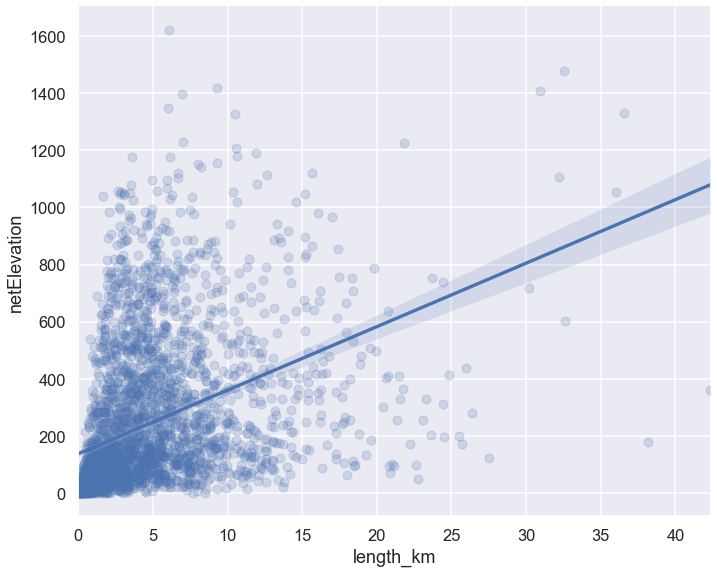

In [91]:
sns.lmplot(x='length_km', y='netElevation', data=df, height=8, aspect=10/8,fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});

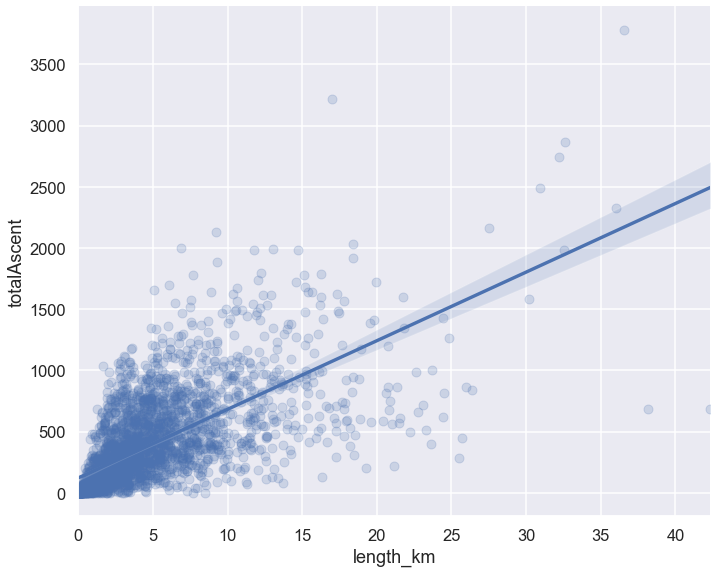

In [92]:
sns.lmplot(x='length_km', y='totalAscent', data=df, height=8, aspect=10/8,fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});

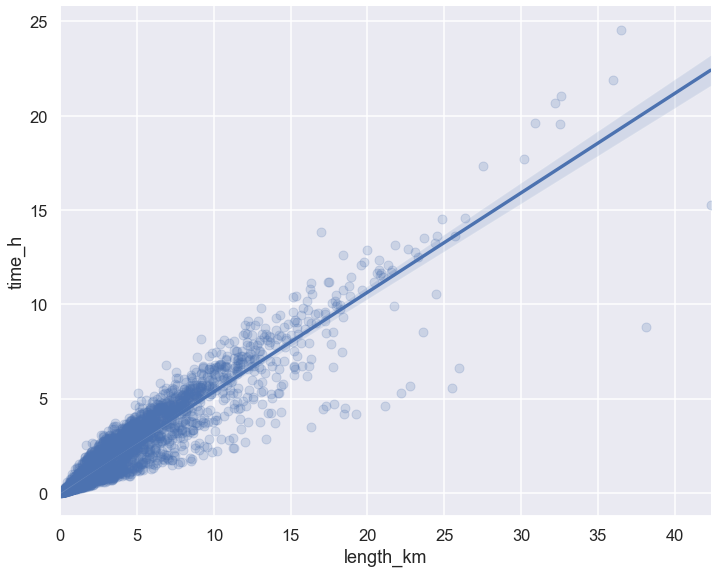

In [93]:
sns.lmplot(x='length_km', y='time_h', data=df, height=8, aspect=10/8,fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});

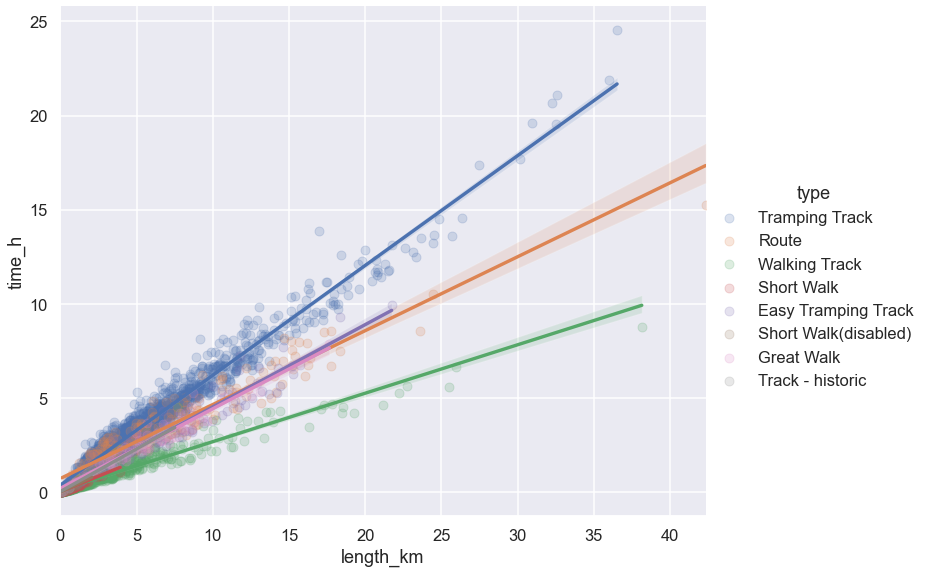

In [97]:
sns.lmplot(x='length_km', y='time_h', data=df, hue='type', height=8, aspect=10/8,fit_reg=True, ci=95, truncate=True, scatter_kws={'alpha':0.2});

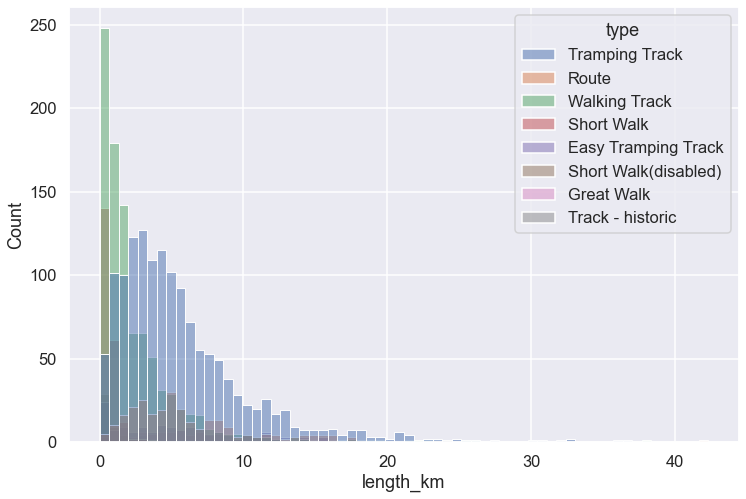

In [109]:
fig,ax = plt.subplots(figsize=(12,8))
sns.histplot(x='length_km', data=df, hue='type', ax=ax);

In [116]:
easy = df[df['totalAscent']<100]['totalAscent'].to_list()
moderate = df[(df['totalAscent']>=100)&(df['totalAscent']<600)]['totalAscent'].to_list()
challenging = df[df['totalAscent']>=600]['totalAscent'].to_list()

In [117]:
print('num. easy: ',len(easy))
print('num. moderate: ',len(moderate))
print('num. challenging: ',len(challenging))

num. easy:  944
num. moderate:  1461
num. challenging:  680
